In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/fufiters_imja_analysis/data'
asc_burst = '012_023790_IW1'
des_burst = '121_258661_IW2'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'imja'
proc_path = f'/home/jovyan/repos/fufiters_imja_analysis/analysis'

# define reference point, [y, x]
reference_point = [3086715.2, 491092.4]

# define crs 
crs = 32645

In [3]:
# read in dam polygon
dam_fn = f'../mapping/polygons/{dam_name}_md.shp'
dam_gdf = gpd.read_file(dam_fn)
dam_gdf = dam_gdf.to_crs(crs) # reproject in case of mistake

# load in moving area polygon
moving_fn = f'../mapping/polygons/{dam_name}_moving.shp'
moving_gdf = gpd.read_file(moving_fn)

# load in moving area polygon
reference_fn = f'../mapping/polygons/{dam_name}_reference.shp'
reference_gdf = gpd.read_file(reference_fn)

# load in stable area polygon
stable_fn = f'../mapping/polygons/{dam_name}_stable.shp'
stable_gdf = gpd.read_file(stable_fn).to_crs(crs)

# load in water mask
water_fn = f'../mapping/polygons/water_mask.shp'
water_gdf = gpd.read_file(water_fn).to_crs(crs)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [dam_gdf.bounds.minx.item()-padding,
               dam_gdf.bounds.maxy.item()+padding,
               dam_gdf.bounds.maxx.item()+padding,
               dam_gdf.bounds.miny.item()-padding]

In [4]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='corr', epsg=32645, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    acquisition_list = []
    
    for idir in dirs:
        tif_path = glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
        #print(src[file_type].shape, src.dates.item())
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [5]:
asc_corr_ds = hyp3_to_xarray(asc_burst_path, file_type=f'corr_{dam_name}')
des_corr_ds = hyp3_to_xarray(des_burst_path, file_type=f'corr_{dam_name}')

In [6]:
asc_corr_ds_12day = asc_corr_ds.where(asc_corr_ds.t_baseline.dt.days == 12 , drop=True)
des_corr_ds_12day = des_corr_ds.where(des_corr_ds.t_baseline.dt.days == 12 , drop=True)

In [7]:
# asc_corr_ds_12day = asc_corr_ds
# des_corr_ds_12day = des_corr_ds

# low coherence period 
asc_lowcorr_ds = asc_corr_ds_12day.where((asc_corr_ds_12day.start_date.dt.dayofyear > 220) & (asc_corr_ds_12day.end_date.dt.dayofyear < 280), drop=True)
des_lowcorr_ds = des_corr_ds_12day.where((des_corr_ds_12day.start_date.dt.dayofyear > 220) & (des_corr_ds_12day.end_date.dt.dayofyear < 280), drop=True)

# high coherence period
asc_highcorr_ds = asc_corr_ds_12day.where(asc_corr_ds_12day.start_date.dt.dayofyear < 100, drop=True)
des_highcorr_ds = des_corr_ds_12day.where(des_corr_ds_12day.start_date.dt.dayofyear < 100, drop=True)

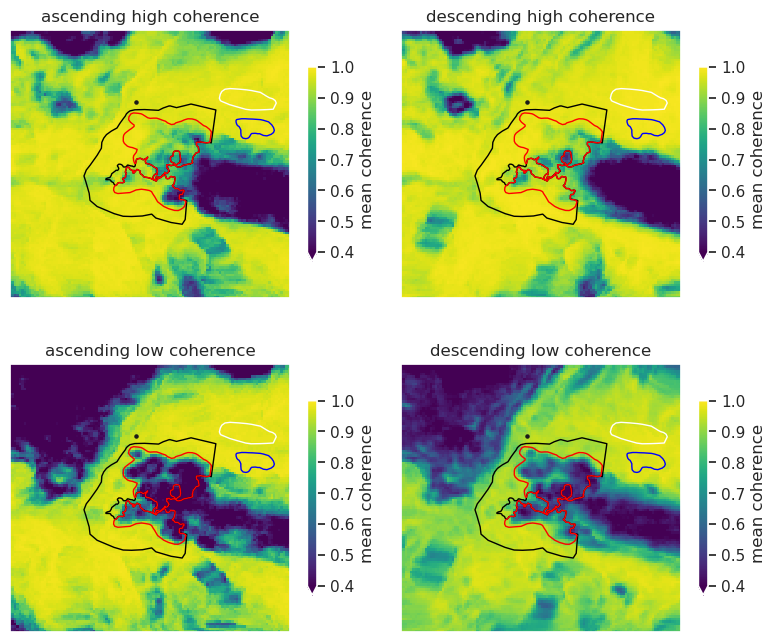

In [14]:
padding = 4400

# plot mean spatial coherence
f, ax = plt.subplots(2, 2, figsize=(8, 7), sharex=True, sharey=True)
asc_highcorr_ds[f'corr_{dam_name}'].median(dim='dates').plot.imshow(ax=ax[0, 0], vmin=0.4, vmax=1, cmap='viridis', cbar_kwargs= {'label':'mean coherence', 'shrink':0.6})
dam_gdf.plot(ax=ax[0, 0], edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax[0, 0], edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax[0, 0], edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax[0, 0], edgecolor='white', facecolor='none')
ax[0, 0].set_title('ascending high coherence')
ax[0, 0].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[0, 0].set_aspect('equal')
ax[0, 0].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[0, 0].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])
ax[0, 0].set_xlabel('')
ax[0, 0].set_ylabel('')

des_highcorr_ds[f'corr_{dam_name}'].median(dim='dates').plot.imshow(ax=ax[0, 1], vmin=0.4, vmax=1, cmap='viridis', cbar_kwargs= {'label':'mean coherence', 'shrink':0.6})
dam_gdf.plot(ax=ax[0, 1], edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax[0, 1], edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax[0, 1], edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax[0, 1], edgecolor='white', facecolor='none')
ax[0, 1].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[0, 1].set_title('descending high coherence')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[0, 1].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')

asc_lowcorr_ds[f'corr_{dam_name}'].median(dim='dates').plot.imshow(ax=ax[1, 0], vmin=0.4, vmax=1, cmap='viridis', cbar_kwargs= {'label':'mean coherence', 'shrink':0.6})
dam_gdf.plot(ax=ax[1, 0], edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax[1, 0], edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax[1, 0], edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax[1, 0], edgecolor='white', facecolor='none')
ax[1, 0].set_title('ascending low coherence')
ax[1, 0].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[1, 0].set_aspect('equal')
ax[1, 0].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[1, 0].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel('')

des_lowcorr_ds[f'corr_{dam_name}'].mean(dim='dates').plot.imshow(ax=ax[1, 1], vmin=0.4, vmax=1, cmap='viridis', cbar_kwargs= {'label':'mean coherence', 'shrink':0.6})
dam_gdf.plot(ax=ax[1, 1], edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax[1, 1], edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax[1, 1], edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax[1, 1], edgecolor='white', facecolor='none')
ax[1, 1].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[1, 1].set_title('descending low coherence')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[1, 1].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[1, 1].set_xlabel('')
ax[1, 1].set_ylabel('')
f.tight_layout()
# plt.savefig(f'./figs/{dam_name}_seasonal_coherence_maps.png', dpi=300)

In [10]:
# combined coherence
asc_lowcorr_da = asc_lowcorr_ds.median(dim='dates').corr_imja
des_lowcorr_da = des_lowcorr_ds.median(dim='dates').corr_imja
# lowcorr_da = xr.where(asc_lowcorr_da < des_lowcorr_da, asc_lowcorr_da, des_lowcorr_da)
lowcorr_da = (asc_lowcorr_da + des_lowcorr_da)/2

asc_highcorr_da = asc_highcorr_ds.median(dim='dates').corr_imja
des_highcorr_da = des_highcorr_ds.median(dim='dates').corr_imja
#  highcorr_da = xr.where(asc_highcorr_da > des_highcorr_da, asc_highcorr_da, des_highcorr_da)
highcorr_da = (asc_highcorr_da + des_highcorr_da)/2

In [13]:
(highcorr_da - lowcorr_da).rio.clip(stable_gdf.geometry, crs=stable_gdf.crs, drop=True).mean(dim=['x', 'y'])

<xarray.DataArray 'corr_imja' ()> Size: 4B
array(0.0015739, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

In [ ]:
lowcorr_da.rio.to_raster('combined_low_coherence.tif')

(3085124.5274983225, 3087299.4173047645)

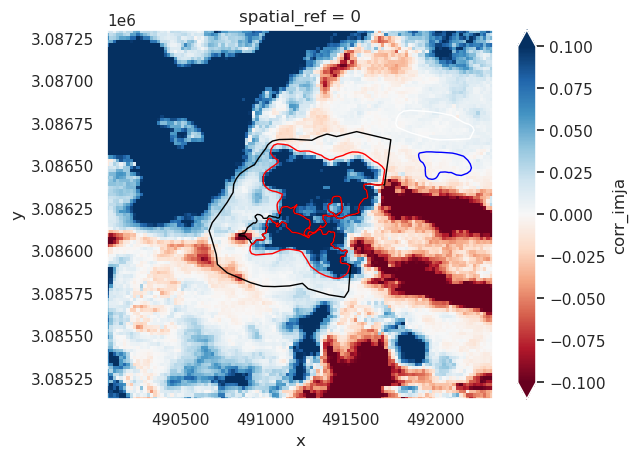

In [16]:
f, ax = plt.subplots()
(high_corr_da - low_corr_da).plot(ax=ax, vmin=-0.1, vmax=0.1, cmap='RdBu')
dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax, edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax, edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax, edgecolor='white', facecolor='none')
ax.set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax.set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)

In [17]:
# save seasonal coherence change
(highcorr_da - lowcorr_da).rio.to_raster('seasonal_coherence_change.tif')